In [1]:
#-----------------数据分析的准备：文件处理-----------------------

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#横坐标显示的定位器
import seaborn as sns
#seaborn精细画图

In [3]:
path=r"D:\项目\自我监测系统项目\苹果手表导出数据\0224.xml"
#shift+ctrl+C 快速复制文件地址
#Raw字符串：把此字符串当成普通字符看 \0

In [4]:
print("文件读取成功")

文件读取成功


In [5]:
tree=ET.parse(path)
root=tree.getroot()
#提取XML文件

In [6]:
df=pd.DataFrame([list.attrib for list in root.findall('Record')])
#把XML转换为DF
#背景：苹果健康数据中，几乎每一条心率，步数，睡眠记录都是以<Record.../>方式存在

In [7]:
print(f"表格大小{df.shape}")
print(f"列名{df.columns}")
print(f"行名{df.index}")
print(f"type:{df['type'].unique()}")
#确认文件内格式结构大致情况

表格大小(38315, 9)
列名Index(['type', 'sourceName', 'sourceVersion', 'unit', 'creationDate',
       'startDate', 'endDate', 'value', 'device'],
      dtype='object')
行名RangeIndex(start=0, stop=38315, step=1)
type:['HKQuantityTypeIdentifierHeight' 'HKQuantityTypeIdentifierBodyMass'
 'HKQuantityTypeIdentifierHeartRate'
 'HKQuantityTypeIdentifierOxygenSaturation'
 'HKQuantityTypeIdentifierRespiratoryRate'
 'HKQuantityTypeIdentifierStepCount'
 'HKQuantityTypeIdentifierDistanceWalkingRunning'
 'HKQuantityTypeIdentifierBasalEnergyBurned'
 'HKQuantityTypeIdentifierActiveEnergyBurned'
 'HKQuantityTypeIdentifierFlightsClimbed'
 'HKQuantityTypeIdentifierAppleExerciseTime'
 'HKQuantityTypeIdentifierRestingHeartRate'
 'HKQuantityTypeIdentifierWalkingHeartRateAverage'
 'HKQuantityTypeIdentifierEnvironmentalAudioExposure'
 'HKQuantityTypeIdentifierHeadphoneAudioExposure'
 'HKQuantityTypeIdentifierWalkingDoubleSupportPercentage'
 'HKQuantityTypeIdentifierAppleStandTime'
 'HKQuantityTypeIdentifierWalkingSpe

In [8]:
df['startDate'] = pd.to_datetime(df['startDate']).dt.tz_localize(None)
df['endDate'] = pd.to_datetime(df['endDate']).dt.tz_localize(None)
#讲DF中的value列原本是字符串格式的时间->python时间对象段
#加上 .dt.tz_localize(None) 去掉苹果手表自带的 +0800 的东八区标签,后续选用就可以直接填想要的时间

In [9]:
#-------------------数据分析的准备：切出想要的时间和数据类型------------

In [10]:
#----------切出时间--------
target_signals={
    'HRV': 'HKQuantityTypeIdentifierHeartRateVariabilitySDNN',
    'HR': 'HKQuantityTypeIdentifierHeartRate',
    'Respiratory': 'HKQuantityTypeIdentifierRespiratoryRate',
    'Oxygen': 'HKQuantityTypeIdentifierOxygenSaturation',
    'Audio': 'HKQuantityTypeIdentifierEnvironmentalAudioExposure'
}
print(f"切出成功")
start_time=pd.to_datetime('2026-02-16 17:00:00')
end_time = pd.to_datetime('2026-02-19 23:00:00')
#还是要to_datetime 因为要转换为python时间对象点
mask = (df['startDate'] >= start_time) & (df['endDate'] <= end_time)
#这里mask只是一个由True和False组成的长列表
print("截取成功")
print(mask.value_counts())

切出成功
截取成功
False    30458
True      7857
Name: count, dtype: int64


In [11]:
#---------选择类型-----------
RecordDF=df.loc[mask].copy()
RecordDF['value']=pd.to_numeric(RecordDF['value'],errors='coerce')

RecordDF['startDate'] = RecordDF['startDate'].dt.tz_localize(None)
RecordDF['endDate'] = RecordDF['endDate'].dt.tz_localize(None)
#！！！因为重新定义变量，所以要重新时区转换！！！很容易忽略

#把value列变成从字符串变成数字
#errors=‘coerce’意思是无法转换就变成空值NaN
#RecordDF=RecordDF.dropna(subset=['value']) #可选要不要去掉NaN，不去掉也会在后面绘图中发现
target_signals={
    'HRV': 'HKQuantityTypeIdentifierHeartRateVariabilitySDNN',
    'HR': 'HKQuantityTypeIdentifierHeartRate',
    'Respiratory': 'HKQuantityTypeIdentifierRespiratoryRate',
    'Oxygen': 'HKQuantityTypeIdentifierOxygenSaturation',
    'Audio': 'HKQuantityTypeIdentifierEnvironmentalAudioExposure'
}
#定义出一个字典
print(f"切出成功")

切出成功


In [12]:
#--------------可视化---------------

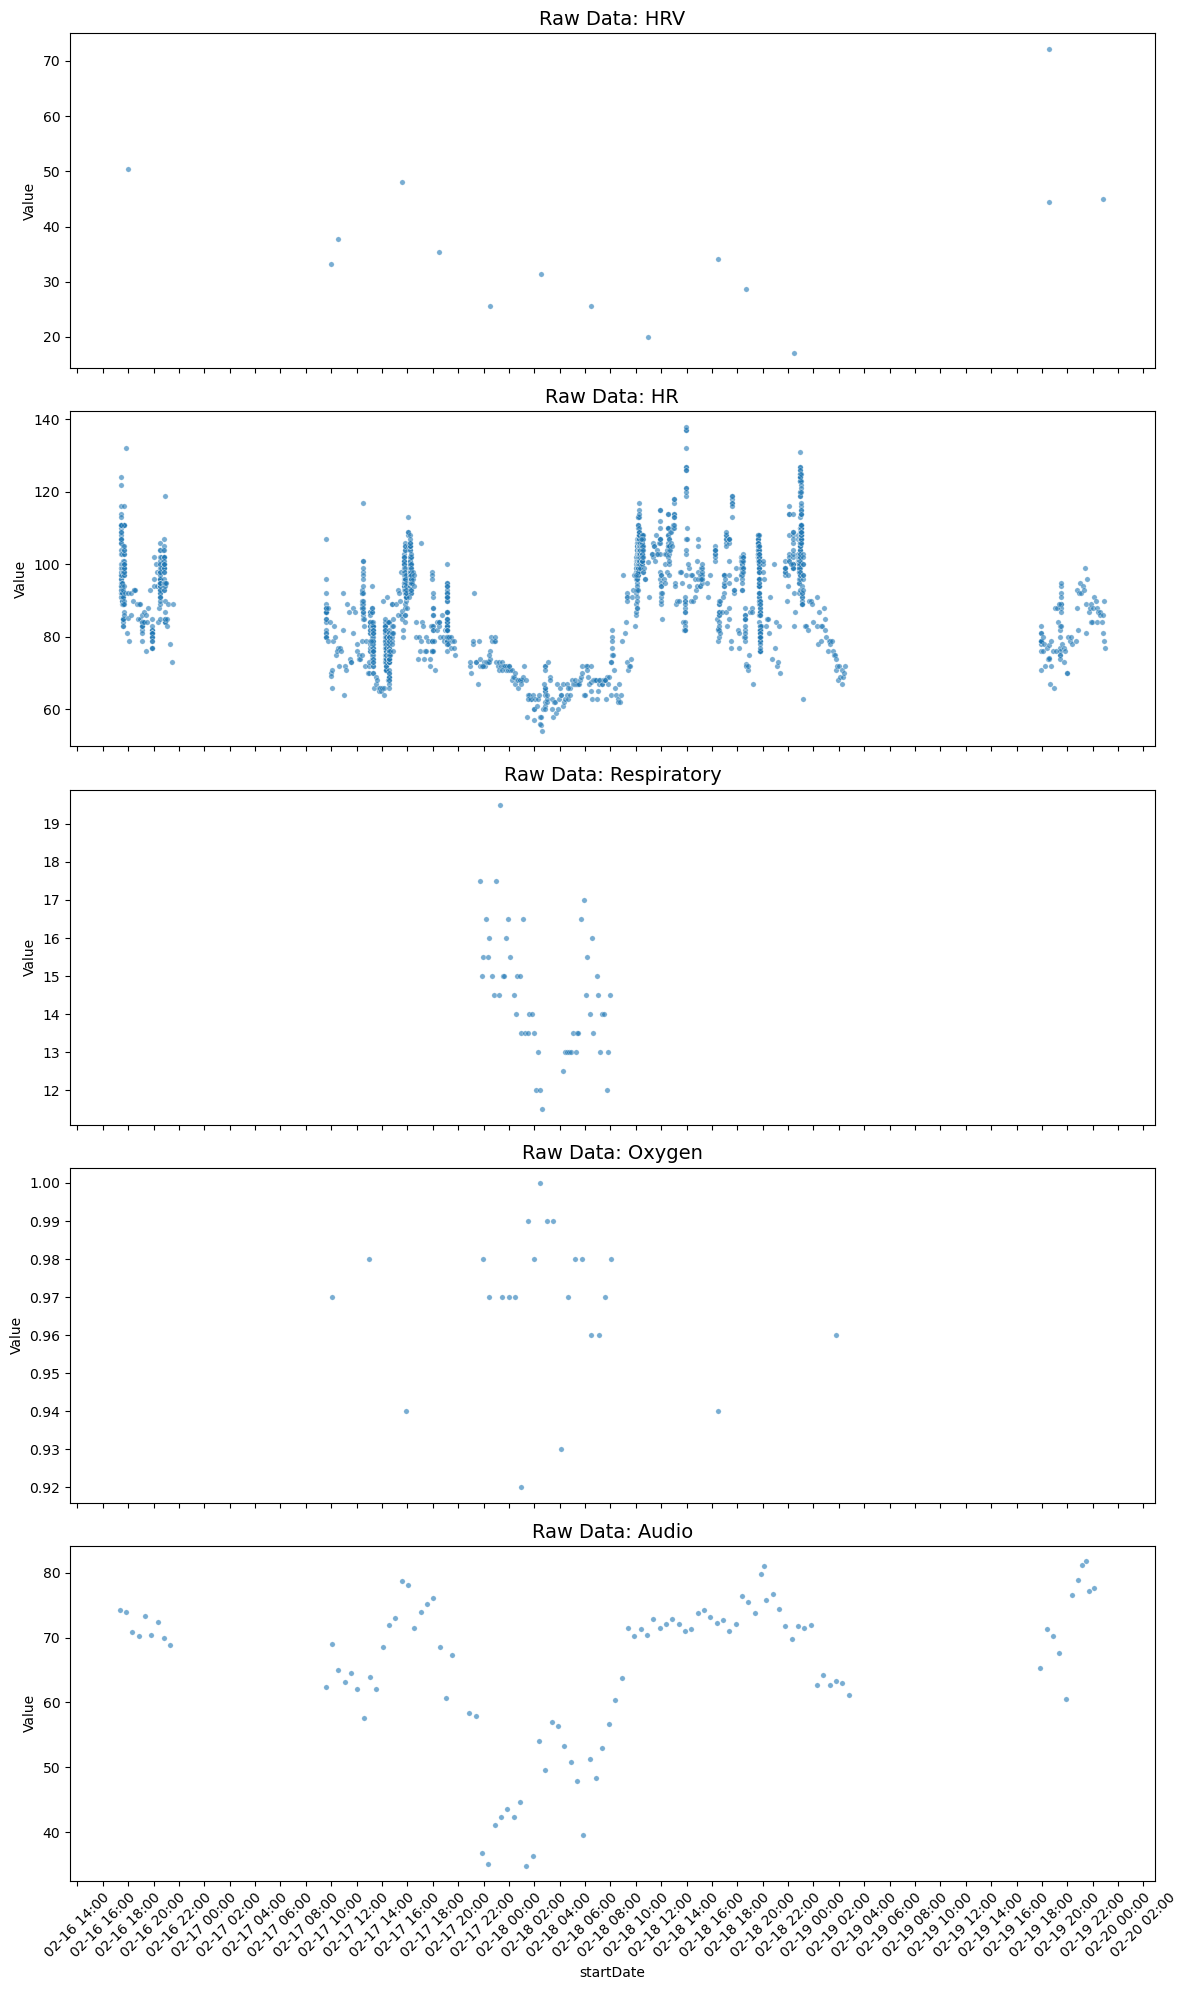

In [13]:
fig, axes = plt.subplots(5, 1, figsize=(12, 20), sharex=True)
#设置画布：尺寸，多少合一，是否统一横坐标
for i, (name, identifier) in enumerate(target_signals.items()):
#.items是键值分离，enumerate:自动编号
#循环轮次,i (序号),name (键),    identifier (值/长ID), 对应画布房间
#第 1 圈, 0,      'HRV',        'HK...SDNN',           axes[0] (最顶上的图)
#第 2 圈, 1,      'HR',         'HK...HeartRate',      axes[1] (第二张图)
#第 3 圈, 2,      'Respiratory','HK...RespiratoryRate',axes[2]
#...,...,...,...,...
    data = RecordDF[RecordDF['type'] == identifier]
    sns.scatterplot(data=data, x='startDate', y='value', ax=axes[i], s=15, alpha=0.6)
#细致画图:
#画散点图先看一下数据缺失情况
#参数：s是点的大小，alpha是透明度

    axes[i].xaxis.set_major_locator(mdates.HourLocator(interval=2))
#选择几个小时显示一次
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    
    axes[i].set_title(f'Raw Data: {name}', fontsize=14)
    axes[i].set_ylabel('Value')
    

    axes[i].tick_params(axis='x', rotation=45) 
#横坐标旋转，避免挤在一起

plt.tight_layout()
#自动调整布局
plt.show()

#Matplot会自动留白，也不用提前留白

In [ ]:
#---------------数据清理--------------

In [ ]:
#应该进行怎么样的处理
#采样的不准确：特别是针对我ADHD趋向很多动，更加难采样，所以要曲线救国。

#遇到的问题：
##个体基线 Baseline记录：每天醒后五分钟内（躺着）测强制测三分钟HRV，HR，呼吸频率，Audio
#（如果受睡眠波动影响大，那就用双层baseline结构，##分析阶段使用##，第一层是长期基线，第二层是当天基线）
##在醒后五分钟内记录

##HRV：苹果手表利用SDNN计算出HRV，大约几个小时才有一次。只在静息状态下记录。
##Respiratory：静息状态才会记录，很零散
##HR:采样频率不固定
#---解决方法：起状态时手动打开正念app，保证个体静息状态记录，不要跟随正念调整呼吸节律
#因为生理变化不会突变，所以保持1-5分钟的静息HRV记录误差在可接受范围，但是可以通过固定延迟减少恢复影响，并且记录下事件发生时间和app开启时间，
#（有记录调节能力的空间）
#-------强制正念会自动形成一个“有价值状态”的label，分析时想找到这些记录就好找了

##Audio：打开噪音app强制记录
##血氧：不作为参考变量

###-------------------加入戴耳机的变量并且主观记录下当时是为什么要戴耳机可以更好状态分析---------------------